Question 2
==

In [1]:
delta = 0.05
beta = 0.98
alpha = 1/3
gamma = 2
u(c) = (c^(1-gamma) - 1)/(1-gamma)
G(k) = k^alpha
F(k::Vector) = u((1-delta)*k[1]+G(k[1])-k[2])

const kbar = ((1/beta+delta-1)/alpha)^(1/(alpha-1))

10.301099814055622

In [2]:
using ForwardDiff
using Roots
using PyPlot

In [3]:
test(x::Vector) = exp(x[2])*x[1]
testr(k) = sum(ForwardDiff.gradient(test,[k,k]))-2*e
fzero(testr,0,10)

1.0

In [39]:
eulersteady(K::Vector) = [reshape(ForwardDiff.gradient(F,[k,k])' * [beta,1], 1)[1] for k in K]
eulersteady(k) = reshape(ForwardDiff.gradient(F,[k,k])' * [beta,1], 1)[1]
fzero(eulersteady, 1, 50)

10.301099814055629

$\bar{k}$ is approximated very well!

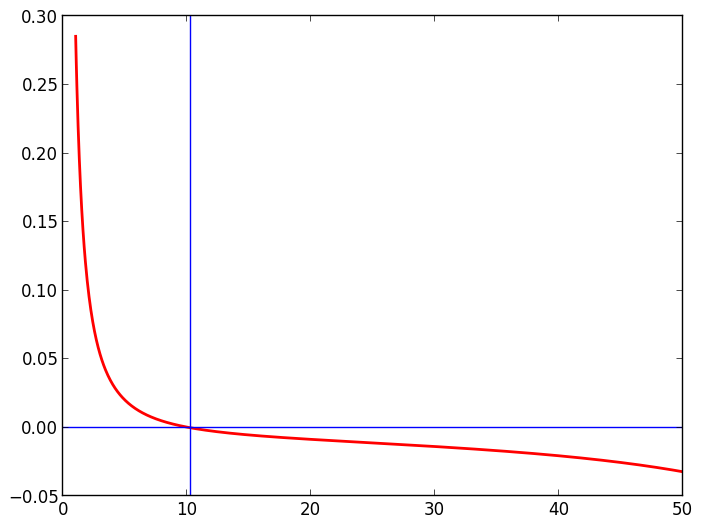

In [5]:
x = linspace(1,50,1000); y = eulersteady(collect(x));
plot(x, y, color="red", linewidth=2.0, linestyle="-")
axhline()
axvline(kbar);

Now lets write the EE as a function of three variables:
$$F_y(k_t,k_{t+1})+\beta \cdot F_x(k_{t+1},k_{t+2})$$

In [6]:
euler(k::Vector) = ForwardDiff.gradient(F,[k[1],k[2]])[2]+beta*ForwardDiff.gradient(F,[k[2],k[3]])[1]

euler (generic function with 1 method)

And Taylor-expand around $\bar{k}$:

In [40]:
eulertaylor(k::Vector) = 0 + ForwardDiff.gradient(euler,[kbar,kbar,kbar])' * [k[1]-kbar,k[2]-kbar,k[3]-kbar]

eulertaylor (generic function with 1 method)

2.1.4.
--

In [55]:
b = 1/beta
a = (beta+1)/beta - beta/gamma*((1/beta + gamma -1)/alpha - delta)*(alpha-1)*(1/beta+delta-1)

2.158666326530612

In [9]:
discr = a^2 - 4*b
(-a + sqrt(discr))/(2), (-a - sqrt(discr))/(2) 

(-0.6991333288900321,-1.45953299764058)

There must be an arithmetic mistake somewhere. I guess one root should be bigger than one (divergent) and one smaller. The latter is the "good" root.
Let's take the numerical values:

In [61]:
D = ForwardDiff.gradient(euler,[kbar,kbar,kbar])
a = D[2]/D[3]
b = D[1]/D[3]
discr = a^2 - 4*b
(-a + sqrt(discr))/(2), (-a - sqrt(discr))/(2) 

(1.07413523283724,0.9499810936933722)

The second root is the good root (TVC holds).

2.1.5.
--

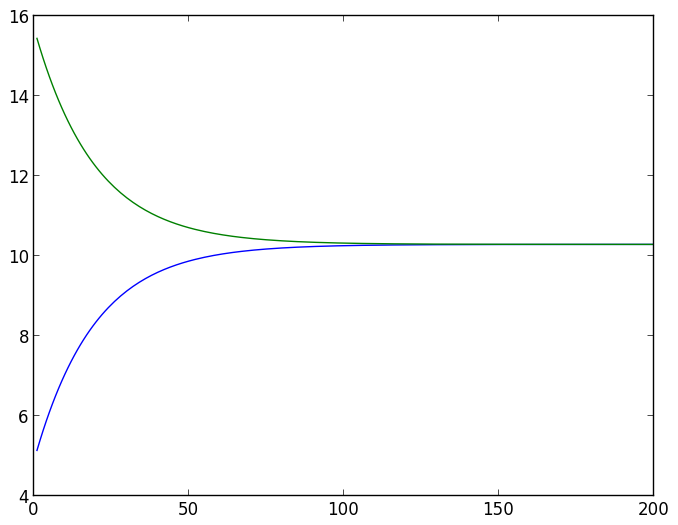

In [68]:
m = (-a - sqrt(discr))/2
linpath1 = (-1/2*kbar)*[m^t for t=0:199]+kbar;
linpath2 = (1/2*kbar)*[m^t for t=0:199]+kbar;
plot(1:200,linpath1);
plot(1:200,linpath2);

In [ ]:
function k2c(k)
    c = Array(Float64,length(k))
    c[1] = 0
    for t in 1:(length(k)-1)
        c[t+1] = (1-delta)*k[t] + G(k[t]) - k[t+1]
    end
    return c
end

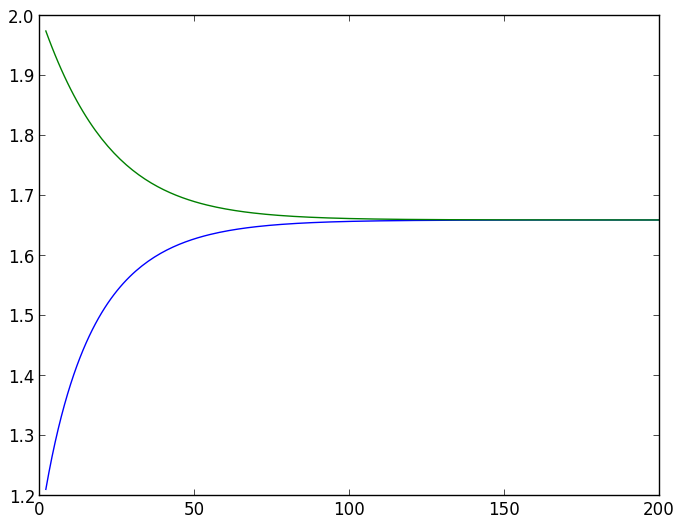

In [71]:
c1 = k2c(linpath1);
c2 = k2c(linpath2);

plot(2:200,c1[2:end]);
plot(2:200,c2[2:end]);

2.1.6.
--
Autoscaling messes things up a bit!

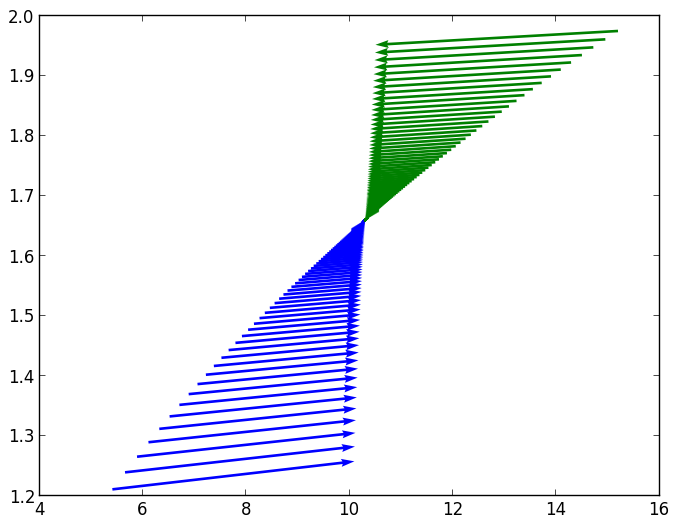

PyObject <matplotlib.quiver.Quiver object at 0x31b6b3990>

In [103]:
quiver(linpath1[2:end], c1[2:end], [linpath1[3:end], linpath1[end]]-linpath1[2:end], [c1[3:end], c1[end]]-c1[2:end],color="b")
quiver(linpath2[2:end], c2[2:end], [linpath2[3:end], linpath2[end]]-linpath2[2:end], [c2[3:end], c2[end]]-c2[2:end],color="g")

2.2.
==

Given $k_{t}$ and $k_{t+1}$ find $k_{t+2}$:

2.2.1.
--
$$k_{t+2} = -\left(\frac{(1-\delta) k_t+k_t^\alpha-k_{t+1})^{-\gamma}}{\beta\left((1-\delta)+\alpha k_{t+1}^{\alpha-1}\right)}\right)^{-\frac{1}{\gamma}} + 
        \left((1-\delta)k_{t+1} + k_{t+1}^\alpha\right)$$

2.2.2.
--

In [19]:
function init_firstguess(k0)
    
    return function firstguess(guess,showplot=false,path=false)
        T=200
        k=Array(Float64,T)
        k[1]=k0
        k[2]=guess

        a,b = k0-1, k0+1;
        n=1;
    
        for t in 3:T
            k[t] = -(((((1-delta)*k[t-2]+k[t-2]^alpha-k[t-1])^(-gamma))/beta/((1-delta)+alpha*k[t-1]^(alpha-1)))^(-1/gamma) - 
            ((1-delta)*k[t-1] + k[t-1]^alpha))
        
            k[t] = maximum([eps(Float64),k[t]])
        end
        if showplot
            plot(1:T,k)
        end

        if path
            return k
        else
            return k[T]-kbar
        end
    end
    
end

init_firstguess (generic function with 1 method)

In [20]:
firstguess = init_firstguess(1/2*kbar)
kt1 = fzero(firstguess,5,6)

5.383348317733769

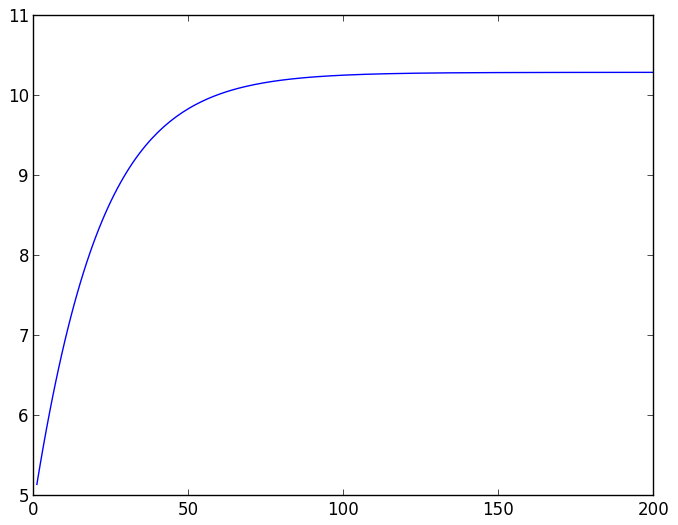

In [21]:
path = firstguess(kt1,true,true);

2.2.3.
--

Fix $k_t$ and use the implicit function theorem on the Euler equation:
$$\frac{\partial{k_{t+2}}}{\partial{k_{t+1}}}=-\frac{1}{EE_{k_{t+2}}}EE_{k_{t+1}}=$$

In [22]:
-1/ForwardDiff.gradient(euler,[kbar,kbar,kbar])[3]*ForwardDiff.gradient(euler,[kbar,kbar,kbar])[2]

2.024116326530612

Mind that this result is only shown for the steady state. Yet, the fact that $F_{xx}<0$, $F_{yy}<0$ and $F_{xy}>0$ makes the result hold globally.

2.2.4.
--
Here are some examples of over/under-shooting paths:

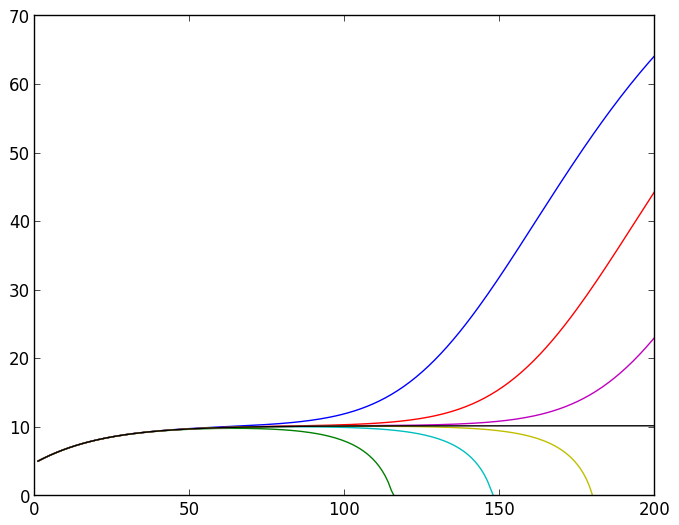

In [23]:
firstguess(kt1+0.0001,true);
plot(1:length(path),firstguess(kt1-0.0001,false,true));
plot(1:length(path),firstguess(kt1+0.00001,false,true));
plot(1:length(path),firstguess(kt1-0.00001,false,true));
plot(1:length(path),firstguess(kt1+0.000001,false,true));
plot(1:length(path),firstguess(kt1-0.000001,false,true));
plot(1:length(path), path);

2.2.5.
--

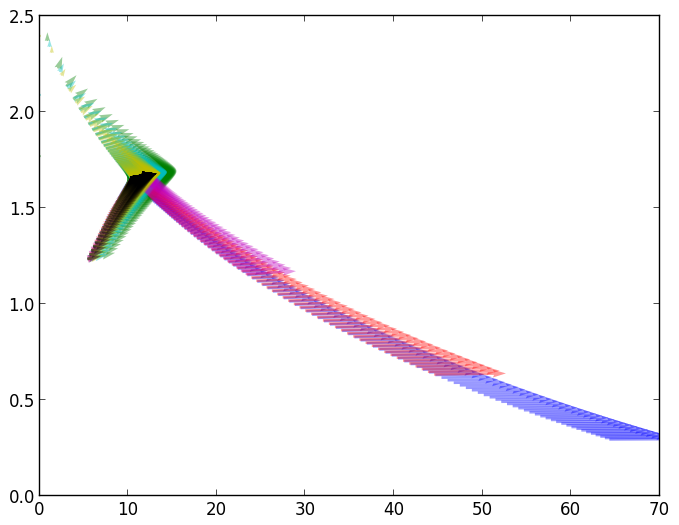

In [27]:
cols = ["b", "g", "r", "c", "m", "y", "k"]
sample = [0.0001,-0.0001,0.00001,-0.00001,0.000001,-0.000001,0]
for g in 1:7
    path = firstguess(kt1+sample[g],false,true);
    c = k2c(path)
    quiver(path[2:end],c[2:end], [path[3:end], path[end]], [c[3:end], c[end]],color=cols[g], alpha=0.4)
end

2.2.6.
--

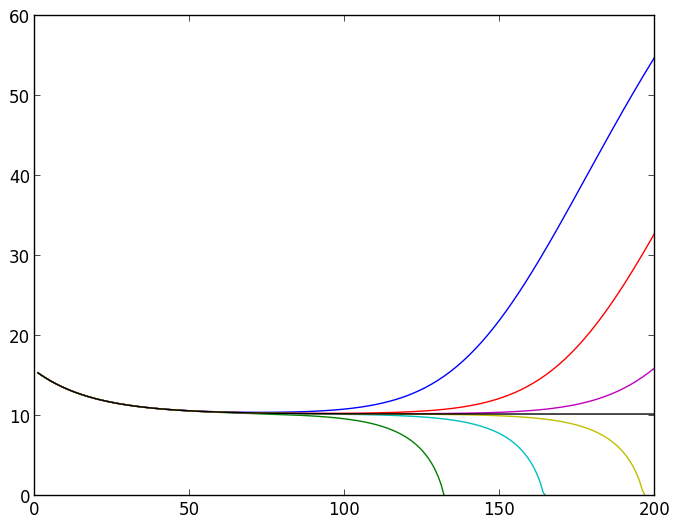

In [35]:
firstguess = init_firstguess(3/2*kbar)
kt1 = fzero(firstguess,12,18)
firstguess(kt1+0.0001,true);
plot(1:length(path),firstguess(kt1-0.0001,false,true));
plot(1:length(path),firstguess(kt1+0.00001,false,true));
plot(1:length(path),firstguess(kt1-0.00001,false,true));
plot(1:length(path),firstguess(kt1+0.000001,false,true));
plot(1:length(path),firstguess(kt1-0.000001,false,true));
plot(1:length(path), path);

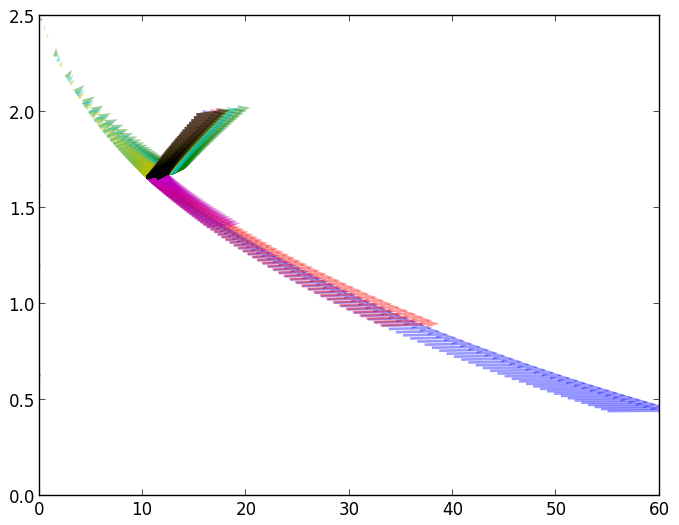

In [36]:
cols = ["b", "g", "r", "c", "m", "y", "k"]
sample = [0.0001,-0.0001,0.00001,-0.00001,0.000001,-0.000001,0]
for g in 1:7
    path = firstguess(kt1+sample[g],false,true);
    c = k2c(path)
    quiver(path[2:end],c[2:end], [path[3:end], path[end]], [c[3:end], c[end]],color=cols[g], alpha=0.4)
end